In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using BenchmarkTools
using Statistics
using AdaptiveTransportMap
using JLD
using Test
using Plots

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [85]:
path = "/media/mat/HDD/AdaptiveTransportMap/src/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 0.7259091433844069
Ne 20 RMSE: 0.47245870340803925
Ne 40 RMSE: 0.42639392022942413
Ne 60 RMSE: 0.45492630492881075
Ne 100 RMSE: 0.4369643653688852
Ne 200 RMSE: 0.4411120758092362
 11.150663 seconds (68.89 M allocations: 6.501 GiB, 7.02% gc time)


In [87]:
Ne = 200

200

In [91]:
metric_list = benchmark_lorenz63(model, data, path, [Ne], [1.0])

(Ne, β) = (200, 1.0)
  8.814201 seconds (62.75 M allocations: 5.935 GiB, 8.71% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.44947610548516914


1-element Array{Any,1}:
 Metrics[Metrics(200, [1.4467600447074953, 1.1994166126003551, 0.6298520501914614, 0.22650555345124632, 0.17919860554237346, 0.2991985860639044, 0.538323450456844, 0.66180941978425, 0.7421442709135765, 0.39088131518253816  …  0.5913993545143394, 0.2589534732288437, 0.16806352260572255, 0.18175361637387757, 0.36753672921589053, 0.710477366946034, 1.2988356558528202, 1.4598870224510287, 0.7552171885152548, 0.35110421876927883], 0.29895174961993065, 0.44947610548516914, 0.3993872244879757, [1.1146582876365874, 1.1263911864442324, 1.1143641814087786, 0.799717722287775, 0.5045895300807101, 0.4270296640740504, 0.5420065266220967, 0.6777634807657188, 0.6363330015076395, 0.5214331578062598  …  0.5394818326798753, 0.4055292634783593, 0.28544330234786025, 0.27425098193588865, 0.38003079535227574, 0.581328492439824, 0.8674703689708166, 0.8578396229646436, 0.6224707726688872, 0.42064523586984587], 0.5385553673542981, 0.5948670662637309, 0.23243814352623532, [1.0, 1.0, 1.0, 

In [15]:
Nx = 3
Ny = 3
Δtdyn = 0.05
Δtobs = 0.1

σx = 1e-2#1e-6#1e-2
σy = 2.0#1e-6#2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)
tspinup = 200.0
Tspinup = 2000
tmetric = 400.0
Tmetric = 4000
t0 = 0.0
tf = 600.0
Tf = 6000

Tburn = 2000
Tstep = 4000
Tspinup = 2000

m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx)

f = lorenz63!
h(t,x) = x
# Create a local version of the observation operator
# h(t,x,idx) = x[idx]

model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, Tburn, Tstep, Tspinup, f, h);

# Set initial condition
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

3-element Array{Float64,1}:
  0.6961989417405797
 -0.07791899150862498
 -0.13351083156896637

In [16]:
# Run dynamics and generate data
data = generate_lorenz63(model, x0, model.Tspinup+model.Tstep);

In [17]:
# Set initial condition
X = zeros(model.Ny + model.Nx, Ne)
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

J = model.Tspinup+model.Tstep
t0 = 0.0
dyn = DynamicalSystem(model.f, model.h)
enkf = StochEnKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, false, false)
# enkf = ETKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, 50*model.Δtobs, false, false)

ETKF  with filtered = false


In [18]:
statehist = seqassim(dyn, data, J, model.ϵx, enkf, X, model.Ny, model.Nx, t0);

In [34]:
# enshist contains the initial condition, so one more element
idx_xt = model.Tstep+1:model.Tspinup+model.Tstep
idx_ens = model.Tstep+model.Tburn+2:model.Tstep+1
# Compute root mean square error statistics
Rmse, Rmse_med, Rmse_mean, Rmse_std = metric_hist(rmse, data.xt[:,idx_xt], statehist[4002:6000])

([1.2556348252148137, 0.7512698156310483, 0.35948499902134085, 0.16455835555020748, 0.18001497388830276, 0.2578423741769609, 0.5219515193536448, 0.8489025659547632, 1.5124189438737223, 1.3787961292679978  …  0.7217710632770823, 0.920357407892724, 1.478629231292147, 1.9895786176631995, 2.2219241839347217, 1.9040739157542412, 1.0774335079355437, 0.8001057316276217, 0.3045765896202186, 0.32866550879288886], 0.48877082752478274, 0.6573520765745268, 0.5505543421532442)

In [43]:
metric_hist(rmse, data.xt[:,idx_xt], statehist[4002:6000])[4]

0.5505543421532442

In [30]:
model.Tstep+model.Tburn+2

6002

In [32]:
statehist

6001-element Array{Array{Float64,2},1}:
 [1.368953110177422 -0.9255033015329047 … 1.6459640369481128 0.5008843941107508; 0.2870875334999468 0.7877455429300264 … 0.44329078703442854 -0.1963899262921777; -0.3697999230745598 -1.1642710703982022 … -0.30749012568553985 0.9829076913724665]
 [2.2687983716483506 1.0751688198363911 … 2.489592184472502 1.5567169509361565; 4.653181782583505 2.452598243367111 … 5.109702942994036 3.1363012155545684; 0.18301783071733152 -0.5934115564035142 … 0.3700068585221903 0.9417235604592032]
 [4.292289944385476 3.219730382926535 … 4.4900867752971845 3.5252848546388966; 9.211547689910857 7.049833710462309 … 9.540137059034981 7.580500197677162; 1.9100350446401109 0.3770374718926357 … 2.412989067045624 1.5673940914012334]
 [9.522801565970092 8.751557181730448 … 9.593978711688942 8.85161904348948; 19.18596327339508 18.383132656679123 … 19.08395517886754 18.313981510767317; 8.490451462967007 5.9507767106456635 … 9.065469812449914 6.908935300125409]
 [18.774888967684

In [28]:
idx_ens

2002:4001

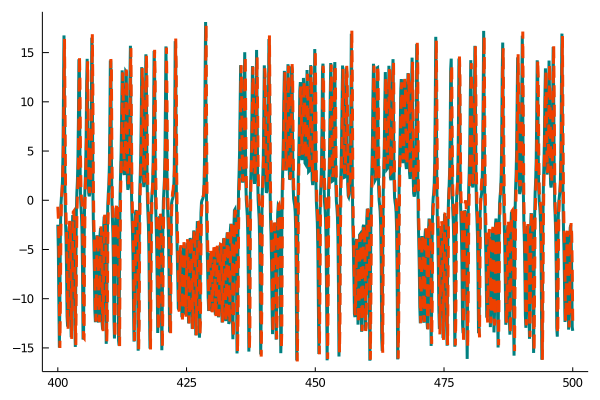

In [44]:
nb = 4000
ne = 5000
Δ = 1
plt = plot()#, size = (1200, 600))
# dict = [L"x_1" L"x_2" L"x_3"]

# plot!(plt[1,i], label = [L"y_k" "Truth" "smap1"])
plot!(plt, data.tt[nb:ne], data.xt[1,nb:ne], linewidth =  3, color = :teal, xlabel = "", 
        ylabel = "", label = "")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(statehist)[1,nb:Δ:ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3, label = "")
# scatter!(plt[1,i], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5,
#     xlim = (-Inf, Inf), ylim = (-Inf, Inf), label = "")
plt

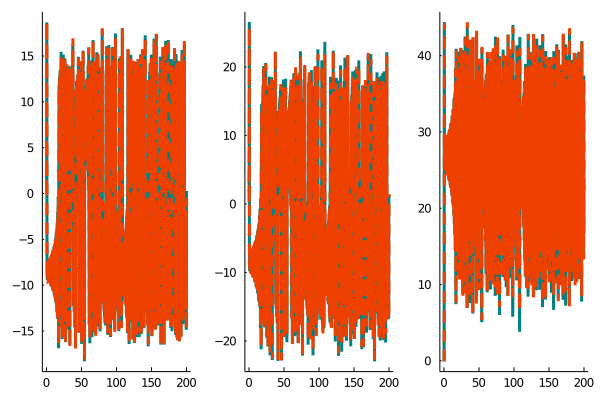

In [21]:
nb = 1
ne = 2000
Δ = 1
plt = plot(layout  = grid(1,3))#, size = (1200, 600))
# dict = [L"x_1" L"x_2" L"x_3"]
for i=1:3
# plot!(plt[1,i], label = [L"y_k" "Truth" "smap1"])
plot!(plt[1,i], data.tt[nb:ne], data.xt[i,nb:ne], linewidth =  3, color = :teal, xlabel = "", 
        ylabel = "", label = "")
plot!(plt[1,i], data.tt[nb:Δ:ne], mean_hist(statehist)[i,nb:Δ:ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, markersize = 3, label = "")
# scatter!(plt[1,i], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5,
#     xlim = (-Inf, Inf), ylim = (-Inf, Inf), label = "")

end

plt